# Logistic Regression

In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import sklearn.linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Simulierte Daten

In [2]:
def generate_prices(observations_count, prices_range):
    return np.random.choice(prices_range, observations_count)

def generate_competitor_prices(observations_count, competitors_count, prices_range):
    return np.matrix([generate_prices(observations_count, prices_range) for i in range(0, competitors_count)])
    
def calculate_ranks(observations_count, competitors_count, competitor_prices, prices):
    return [1 + len([1 for j in range(competitors_count) if competitor_prices[j,i] < prices[i]])
            for i in range(observations_count)]

def calculate_sold_probs_A(observations_count, ranks, competitors_count, prices):
    max_prob = lambda i: 1 - ((0.3 * ranks[0][i])/(competitors_count[0] + 1)) - 0.05 * prices[0][i] + (-0.0125 * (prices[0][i] - prices[1][i]) + 0.25)
    return [np.maximum(0, np.round(np.random.uniform(0, max_prob(i)))) for i in range(observations_count)]

def calculate_sold_probs_B(observations_count, ranks, competitors_count, prices):
    max_prob = lambda i: 1 - ((0.3 * ranks[1][i])/(competitors_count[1] + 1)) - 0.05 * prices[1][i] + (0.0125 * (prices[0][i] - prices[1][i]) + 0.25)
    return [np.maximum(0, np.round(np.random.uniform(0, max_prob(i)))) for i in range(observations_count)]

observations_count = 1000
prices_ranges = [np.arange(1, 20.1, 0.1) for i in range(2)] #TODO adopt prob function if price changes
prices = [generate_prices(observations_count, prices_ranges[i]) for i in range(2)] # TODO p1 > p2?
competitors_count = [2, 2]
competitor_prices = [generate_competitor_prices(observations_count, competitors_count[i], prices_ranges[i]) for i in range(2)]
ranks = [calculate_ranks(observations_count, competitors_count[i], competitor_prices[i], prices[i]) for i in range(2)]
sold = [calculate_sold_probs_A(observations_count, ranks, competitors_count, prices),
        calculate_sold_probs_B(observations_count, ranks, competitors_count, prices)]

## Regression

In [3]:
def get_explanatory_vars_A(observations_count, competitors_count, ranks, competitor_prices):
    explanatory_1 = [1 for j in range(observations_count)]
    explanatory_2 = [ranks[0][j] for j in range(observations_count)]
    
    def get_all_competitor_prices(j):
        for i in range(2):
            for k in range(competitors_count[i]):
                yield competitor_prices[i][k,j]
    explanatory_3 = [prices[0][j] - np.min(list(get_all_competitor_prices(j))) for j in range(observations_count)]
    explanatory_4 = [prices[0][j] - np.min([prices[i][j] for i in range(2)]) for j in range(observations_count)]
    explanatory_5 = [math.pow(explanatory_4[j], 2) for j in range(observations_count)]
    return np.matrix([explanatory_1, explanatory_2, explanatory_3, explanatory_4, explanatory_5])

def get_explanatory_vars_B(observations_count, competitors_count, ranks, competitor_prices):
    explanatory_1 = [1 for j in range(observations_count)]
    explanatory_2 = [ranks[1][j] for j in range(observations_count)]
    
    def get_all_competitor_prices(j):
        for i in range(2):
            for k in range(competitors_count[i]):
                yield competitor_prices[i][k,j]
    explanatory_3 = [prices[1][j] - np.min(list(get_all_competitor_prices(j))) for j in range(observations_count)]
    explanatory_4 = [prices[1][j] - np.min([prices[i][j] for i in range(2)]) for j in range(observations_count)]
    explanatory_5 = [math.pow(explanatory_4[j], 2) for j in range(observations_count)]
    return np.matrix([explanatory_1, explanatory_2, explanatory_3, explanatory_4, explanatory_5])

explanatory_vars = [get_explanatory_vars_A(observations_count, competitors_count, ranks, competitor_prices),
                    get_explanatory_vars_B(observations_count, competitors_count, ranks, competitor_prices)]
logits = [sm.Logit(sold[i], explanatory_vars[i].transpose()) for i in range(2)]
results = [logits[i].fit() for i in range(2)]
beta = [results[i].params for i in range(2)]
beta

Optimization terminated successfully.
         Current function value: 0.353806
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.334113
         Iterations 11


[array([ 0.42649208, -0.84314137, -0.08157649, -0.03072875, -0.03500331]),
 array([ 0.54854323, -0.64243022, -0.14920694, -0.18757081, -0.03838102])]

In [4]:
[results[i].aic for i in range(2)]

[717.61141402060275, 678.22618554690143]

## Optimierung

In [5]:
def get_price_index(price):
    return int(price / 0.1 - 10) # TODO dependent on price range?

def calculate_sale_probs(beta, explanatory_vars, prices_ranges):
    L = lambda price_A, price_B: np.sum([beta[m] * explanatory_vars[m, get_price_index(price_A), get_price_index(price_B)] for m in range(len(beta))])
    return np.matrix([[np.exp(L(price_A, price_B)) / (1 + np.exp(L(price_A, price_B))) for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])

def bellman(n, sale_probs, prices_range, holding_cost_rate, delta, values, step):
    prob_A = lambda price_A, price_B, i: sale_probs[get_price_index(price_A), get_price_index(price_B), 0, i]
    prob_B = lambda price_A, price_B, i: sale_probs[get_price_index(price_A), get_price_index(price_B), 1, i]
    todays_profit = lambda prices, j, i: np.min([n[j], i]) * prices[j] - n[j] * holding_cost_rate[j]
    disc_exp_fut_profits = lambda i, j: delta * values[step + 1, np.max([0, n[0]-i]), np.max([0, n[1]-j])]

    bellman_for_combinations = []
    for price_A in prices_range[0]:
        for price_B in prices_range[1]:
            bellman_for_combinations.append(np.sum([prob_A(price_A, price_B, i) * np.sum([prob_B(price_A, price_B, j) * ((todays_profit([price_A, price_B], 0, i)+todays_profit([price_A, price_B], 1, j)) + disc_exp_fut_profits(i,j)) for j in range(2)]) for i in range(2)]))
    return np.max(bellman_for_combinations)

def bellman_check(n, sale_probs, prices, holding_cost_rate, delta, values, t):
    prob_A = lambda price_A, price_B, i: sale_probs[get_price_index(price_A), get_price_index(price_B), 0, i]
    prob_B = lambda price_A, price_B, i: sale_probs[get_price_index(price_A), get_price_index(price_B), 1, i]
    todays_profit = lambda prices, j, i: np.min([n[j], i]) * prices[j] - n[j] * holding_cost_rate[j]
    disc_exp_fut_profits = lambda i, j: delta * values[t + 1, np.max([0, n[0]-i]), np.max([0, n[1]-j])]

    return np.sum([prob_A(prices[0], prices[1], i) * np.sum([prob_B(prices[0], prices[1], j) * ((todays_profit(prices, 0, i)+todays_profit(prices, 1, j)) + disc_exp_fut_profits(i,j)) for j in range(2)]) for i in range(2)])

In [6]:
competitor_prices = [generate_prices(competitors_count[i],prices_ranges[i]) for i in range(2)]

def get_explanatory_vars_A(prices_ranges, competitors_count, competitor_prices):
    def get_all_competitor_prices():
        for i in range(2):
            for k in range(competitors_count[i]):
                yield competitor_prices[i][k]
    
    explanatory_1 = np.matrix([[1 for price_A in prices_ranges[0]] for price_B in prices_ranges[1]])
    explanatory_2 = np.matrix([[1 + len([1 for j in range(competitors_count[0]) if competitor_prices[0][j] < price_A]) for price_B in prices_ranges[1]] for price_B in prices_ranges[0]])
    explanatory_3 = np.matrix([[price_A - np.min(list(get_all_competitor_prices())) for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    explanatory_4 = np.matrix([[price_A - np.min([price_A, price_B]) for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    explanatory_5 = np.matrix([[math.pow(explanatory_4[price_A, price_B], 2) for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    
    return np.array([explanatory_1, explanatory_2, explanatory_3, explanatory_4, explanatory_5])

def get_explanatory_vars_B(prices_ranges, competitors_count, competitor_prices):
    def get_all_competitor_prices():
        for i in range(2):
            for k in range(competitors_count[i]):
                yield competitor_prices[i][k]
    
    explanatory_1 = np.matrix([[1 for price_A in prices_ranges[0]] for price_B in prices_ranges[1]])
    explanatory_2 = np.matrix([[1 + len([1 for j in range(competitors_count[1]) if competitor_prices[1][j] < price_B]) for price_A in prices_ranges[0]] for price_B in prices_ranges[1]])
    explanatory_3 = np.matrix([[price_B - np.min(list(get_all_competitor_prices())) for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    explanatory_4 = np.matrix([[price_B - np.min([price_A, price_B]) for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    explanatory_5 = np.matrix([[math.pow(explanatory_4[price_A, price_B], 2) for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    
    return np.array([explanatory_1, explanatory_2, explanatory_3, explanatory_4, explanatory_5])

explanatory_vars = [get_explanatory_vars_A(prices_ranges, competitors_count, competitor_prices),
                    get_explanatory_vars_B(prices_ranges, competitors_count, competitor_prices)]

In [7]:
p = [calculate_sale_probs(beta[i], explanatory_vars[i], prices_ranges) for i in range(2)]
sale_probs = np.array([[[[1 - p[i][get_price_index(price_A), get_price_index(price_B)], p[i][get_price_index(price_A), get_price_index(price_B)]] for i in range(2)] for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])

In [8]:
sale_probs[0][0][0][0]

0.85324857622985018

In [9]:
delta = 0.99
holding_cost_rate = [0.01, 0.01]
init_inventory = [3, 3]
steps = 50
values = np.empty(shape=(steps + 1, init_inventory[0] + 1, init_inventory[1] + 1))
for step in range(steps, -1, -1):
    for n_A in range(init_inventory[0] + 1):
        for n_B in range(init_inventory[1] + 1):
            if step == steps or n_A == 0 or n_B == 0:
                values[step, n_A, n_B] = 0
            else:
                values[step, n_A, n_B] = bellman([n_A, n_B], sale_probs, prices_ranges, holding_cost_rate, delta, values, step)

def opt_p(t):
    opt_prices = np.zeros(shape=(init_inventory[0] + 1, init_inventory[1] + 1, 2))
    for n_A in range(1, init_inventory[0] + 1):
        for n_B in range(1, init_inventory[1] + 1):
            for price_A in prices_ranges[0]:
                for price_B in prices_ranges[1]:
                    if bellman_check([n_A, n_B], sale_probs, [price_A, price_B], holding_cost_rate, delta, values, t) == values[t, n_A, n_B]:
                        opt_prices[n_A, n_B, 0] = price_A
                        opt_prices[n_A, n_B, 1] = price_B
    return opt_prices
                    
opt_prices = opt_p(0)
for n_A in range(init_inventory[0] + 1):
    for n_B in range(init_inventory[1] + 1):
        print('n_A: ' + str(n_A) + ',n_B: ' + str(n_B) + ' - A: ' + str(opt_prices[n_A, n_B, 0]) + ',B: ' + str(opt_prices[n_A, n_B, 1]))

n_A: 0,n_B: 0 - A: 0.0,B: 0.0
n_A: 0,n_B: 1 - A: 0.0,B: 0.0
n_A: 0,n_B: 2 - A: 0.0,B: 0.0
n_A: 0,n_B: 3 - A: 0.0,B: 0.0
n_A: 1,n_B: 0 - A: 0.0,B: 0.0
n_A: 1,n_B: 1 - A: 19.8,B: 20.0
n_A: 1,n_B: 2 - A: 19.8,B: 15.9
n_A: 1,n_B: 3 - A: 19.8,B: 13.4
n_A: 2,n_B: 0 - A: 0.0,B: 0.0
n_A: 2,n_B: 1 - A: 19.9,B: 20.0
n_A: 2,n_B: 2 - A: 19.8,B: 19.8
n_A: 2,n_B: 3 - A: 19.8,B: 17.3
n_A: 3,n_B: 0 - A: 0.0,B: 0.0
n_A: 3,n_B: 1 - A: 12.7,B: 20.0
n_A: 3,n_B: 2 - A: 19.8,B: 19.8
n_A: 3,n_B: 3 - A: 18.5,B: 18.5


## Simulation

In [10]:
c_prices_time_A = np.empty(shape=(competitors_count[0], steps))
for c in range(competitors_count[0]):
    c_prices_time_A[c,0] = competitor_prices[0][c]
c_prices_time_B = np.empty(shape=(competitors_count[1], steps))
for c in range(competitors_count[1]):
    c_prices_time_B[c,0] = competitor_prices[1][c]
    
inventory_time_A = np.empty(shape=(steps))
for t in range(steps):
    inventory_time_A[t] = init_inventory[0]
inventory_time_B = np.empty(shape=(steps))
for t in range(steps):
    inventory_time_B[t] = init_inventory[1]

o_prices_time_A = np.zeros(shape=(steps))
o_prices_time_B = np.zeros(shape=(steps))
o_prices_time_A[0] = opt_prices[init_inventory[0], init_inventory[1]][0]
o_prices_time_B[0] = opt_prices[init_inventory[0], init_inventory[1]][1]

for t in range(1,steps):
    if ((inventory_time_A[t] > 0) and (np.random.uniform(0,1) < sale_probs[get_price_index(o_prices_time_A[t-1]), get_price_index(o_prices_time_B[t-1]), 0, 1])):
        inventory_time_A[t] = np.max([0, inventory_time_A[t-1]-1])
    else:
        inventory_time_A[t] = inventory_time_A[t-1]
        
    if ((inventory_time_B[t] > 0) and (np.random.uniform(0,1) < sale_probs[get_price_index(o_prices_time_A[t-1]), get_price_index(o_prices_time_B[t-1]), 1, 1])):
        inventory_time_B[t] = np.max([0, inventory_time_B[t-1]-1])
    else:
        inventory_time_B[t] = inventory_time_B[t-1]
        
    #for c in range(competitors_count):
        #if (np.random.uniform(0,1) < 0.2):
            #c_prices_time[c,t]= np.round(c_prices_time[c,t-1] * np.random.uniform(0.8, 1.2), 1)
            
    if (inventory_time_A[t] > 0) or (inventory_time_B[t] > 0):
        opt_prices_n = opt_p(t)
        o_prices_time_A[t] = opt_prices_n[int(inventory_time_A[t]), int(inventory_time_B[t])][0]
        o_prices_time_B[t] = opt_prices_n[int(inventory_time_A[t]), int(inventory_time_B[t])][1]

In [11]:
inventory_time_A

array([ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.])

In [12]:
inventory_time_B

array([ 3.,  3.,  3.,  3.,  3.,  3.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.])

In [13]:
o_prices_time_A

array([ 18.5,  18.4,  18.3,  18.2,  18.1,  18. ,  19.8,  19.8,  19.8,
        19.8,  19.8,  19.8,  19.8,  19.8,  19.8,  19.7,  19.6,  19.4,
        19.3,  19.1,  18.9,  18.8,  18.6,  12.9,  12.9,  12.9,  13.1,
        13.2,  13.4,  13.5,  13.7,  14. ,  14.2,  14.7,  15.4,  19.8,
        19.8,  19.8,  19.7,  19.2,  18.7,  18.1,  17.6,  16.9,  16.1,
        15.1,  14.1,  12.8,   0. ,   0. ])

In [14]:
o_prices_time_B

array([ 18.5,  18.4,  18.3,  18.2,  18.1,  18. ,  19.8,  19.8,  19.8,
        19.8,  19.8,  19.8,  19.8,  19.8,  19.8,  19.7,  19.6,  19.4,
        19.3,  19.1,  18.9,  18.8,  18.6,  20. ,  20. ,  20. ,  20. ,
        20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,
        19.8,  19.8,  19.7,  19.2,  18.7,  18.1,  17.6,  16.9,  16.1,
        15.1,  14.1,  12.8,   0. ,   0. ])

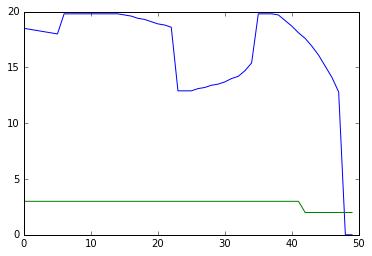

In [15]:
plt.plot(range(0,50),o_prices_time_A, range(0,50),inventory_time_A)
plt.axis([0,50,0,20])
plt.show()

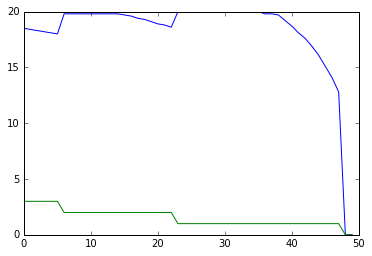

In [16]:
plt.plot(range(0,50),o_prices_time_B, range(0,50),inventory_time_B)
plt.axis([0,50,0,20])
plt.show()